In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

Bin values should be from -6.5 to 6.5 instead of starting at -5.5

Inputs are everything in summary file + Precursor, Gas, and Aerosol
StandardScaler

In [3]:
summary_file = "/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene/GAR0084_Exp_List_TEXT_PreCompile_BatchSubmit_v0.csv"
summary_data = pd.read_csv(summary_file, skiprows=3)
summary_data.columns = summary_data.columns.str.strip()
summary_data.columns
summary_data["idnum"] = summary_data.index

In [25]:
summary_data

,id,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),idnum
0,Exp0,270.0,0.0,0.01,1.0,0.01,1.0,0
1,Exp1,270.0,0.0,0.01,1.0,0.01,5.0,1
2,Exp2,270.0,0.0,0.01,1.0,0.01,10.0,2
3,Exp3,270.0,0.0,0.01,1.0,0.10,1.0,3
4,Exp4,270.0,0.0,0.01,1.0,0.10,5.0,4
...,...,...,...,...,...,...,...,...
5395,Exp5395,300.0,90.0,100.00,150.0,3.00,5.0,5395
5396,Exp5396,300.0,90.0,100.00,150.0,3.00,10.0,5396
5397,Exp5397,300.0,90.0,100.00,150.0,10.00,1.0,5397
5398,Exp5398,300.0,90.0,100.00,150.0,10.00,5.0,5398


In [5]:
def load_data(path, summary_file, species="toluene_kOH"):
    summary_data = pd.read_csv(join(path, summary_file), skiprows=3)
    summary_data.columns = summary_data.columns.str.strip()
    exp_data_list = []
    for i, id_val in enumerate(summary_data["id"]):
        if i % 100 == 0:
            print(id_val)
        exp_file = join(path, f"ML2019_{species}_ML2019_{id_val}.csv")
        exp_data_list.append(pd.read_csv(exp_file))
        exp_data_list[-1]["id"] = id_val
        exp_data_list[-1]["idnum"] = i
    exp_data_combined = pd.concat(exp_data_list, ignore_index=True)
    exp_data_combined.columns = exp_data_combined.columns.str.strip()
    exp_data_merged = pd.merge(exp_data_combined, summary_data, left_on="id", right_on="id")
    return exp_data_merged, summary_data
    

In [6]:
exp_data_merged, summary_data = load_data("/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene", 
                                          "GAR0084_Exp_List_TEXT_PreCompile_BatchSubmit_v0.csv")

Exp0
Exp100
Exp200
Exp300
Exp400
Exp500
Exp600
Exp700
Exp800
Exp900
Exp1000
Exp1100
Exp1200
Exp1300
Exp1400
Exp1500
Exp1600
Exp1700
Exp1800
Exp1900
Exp2000
Exp2100
Exp2200
Exp2300
Exp2400
Exp2500
Exp2600
Exp2700
Exp2800
Exp2900
Exp3000
Exp3100
Exp3200
Exp3300
Exp3400
Exp3500
Exp3600
Exp3700
Exp3800
Exp3900
Exp4000
Exp4100
Exp4200
Exp4300
Exp4400
Exp4500
Exp4600
Exp4700
Exp4800
Exp4900
Exp5000
Exp5100
Exp5200
Exp5300


In [8]:
exp_data_merged.loc[exp_data_merged["idnum"] == 10]

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -5.5,Gas [ug/m3] Bin02: lg(C*) = -4.5,Gas [ug/m3] Bin03: lg(C*) = -3.5,Gas [ug/m3] Bin04: lg(C*) = -2.5,Gas [ug/m3] Bin05: lg(C*) = -1.5,Gas [ug/m3] Bin06: lg(C*) = -0.5,Gas [ug/m3] Bin07: lg(C*) = 0.5,Gas [ug/m3] Bin08: lg(C*) = 1.5,...,N/C Bin13: lg(C*) = 6.5,N/C Bin14: lg(C*) = -6.5,id,idnum,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
5760,1.000000,0.037689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
5761,301.519989,0.037332,1.113952e-21,4.070264e-20,6.686731e-17,1.389201e-16,4.066288e-15,1.757855e-13,9.118843e-12,5.212791e-12,...,0.003095,0.001404,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
5762,602.039978,0.036979,8.465895e-21,2.655437e-19,1.143732e-16,1.790802e-15,2.412341e-14,4.494002e-12,6.651374e-11,3.789099e-11,...,0.006236,0.001658,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
5763,902.559998,0.036628,3.248028e-20,7.934065e-19,2.488888e-15,9.371479e-15,1.919735e-13,2.865727e-11,2.018920e-10,1.266861e-10,...,0.008816,0.001925,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
5764,1203.079956,0.036281,1.030769e-19,2.069284e-18,3.476972e-15,2.874213e-14,4.096286e-13,1.022437e-10,4.320647e-10,2.948841e-10,...,0.011113,0.002200,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,171597.921875,0.000165,1.043278e-13,1.525949e-12,1.460513e-10,1.237334e-09,3.408873e-08,1.015127e-06,4.097190e-07,9.564674e-09,...,0.015083,0.170063,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
6332,171898.437500,0.000163,1.041344e-13,1.523302e-12,1.458010e-10,1.234989e-09,3.408640e-08,1.008500e-06,4.094157e-07,9.512465e-09,...,0.015061,0.170112,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
6333,172198.953125,0.000162,1.039410e-13,1.520657e-12,1.455456e-10,1.232646e-09,3.408390e-08,1.001909e-06,4.091112e-07,9.417578e-09,...,0.015039,0.170160,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0
6334,172499.484375,0.000160,1.037479e-13,1.518013e-12,1.452935e-10,1.230307e-09,3.408143e-08,9.953547e-07,4.088050e-07,9.325147e-09,...,0.015017,0.170209,Exp10,10,270.0,0.0,0.01,1.0,1.0,5.0


In [9]:
input_exp_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -5.5',
    'Gas [ug/m3] Bin02: lg(C*) = -4.5',
    'Gas [ug/m3] Bin03: lg(C*) = -3.5',
    'Gas [ug/m3] Bin04: lg(C*) = -2.5',
    'Gas [ug/m3] Bin05: lg(C*) = -1.5',
    'Gas [ug/m3] Bin06: lg(C*) = -0.5',
    'Gas [ug/m3] Bin07: lg(C*) =  0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  1.5',
    'Gas [ug/m3] Bin09: lg(C*) =  2.5',
    'Gas [ug/m3] Bin10: lg(C*) =  3.5',
    'Gas [ug/m3] Bin11: lg(C*) =  4.5',
    'Gas [ug/m3] Bin12: lg(C*) =  5.5',
    'Gas [ug/m3] Bin13: lg(C*) =  6.5',
    'Gas [ug/m3] Bin14: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
    'temperature (K)',
    'solar zenith angle (degree)',
    'pre-existing aerosols (ug/m3)',
    'o3 (ppb)',
    'nox (ppb)',
    'oh (10^6 molec/cm3)']

output_exp_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -5.5',
    'Gas [ug/m3] Bin02: lg(C*) = -4.5',
    'Gas [ug/m3] Bin03: lg(C*) = -3.5',
    'Gas [ug/m3] Bin04: lg(C*) = -2.5',
    'Gas [ug/m3] Bin05: lg(C*) = -1.5',
    'Gas [ug/m3] Bin06: lg(C*) = -0.5',
    'Gas [ug/m3] Bin07: lg(C*) =  0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  1.5',
    'Gas [ug/m3] Bin09: lg(C*) =  2.5',
    'Gas [ug/m3] Bin10: lg(C*) =  3.5',
    'Gas [ug/m3] Bin11: lg(C*) =  4.5',
    'Gas [ug/m3] Bin12: lg(C*) =  5.5',
    'Gas [ug/m3] Bin13: lg(C*) =  6.5',
    'Gas [ug/m3] Bin14: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',]

In [31]:
input_data_list = []
output_data_list = []
for exp in np.unique(exp_data_merged.idnum):
    if exp % 100 == 0:
        print(exp)
    input_data_list.append(exp_data_merged.loc[exp_data_merged.idnum==exp, input_exp_cols].reset_index(drop=True).iloc[:-1])
    output_data_list.append(exp_data_merged.loc[exp_data_merged.idnum==exp, input_exp_cols].reset_index(drop=True).iloc[1:])
input_data = pd.concat(input_data_list, ignore_index=True)
output_data = pd.concat(output_data_list, ignore_index=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300


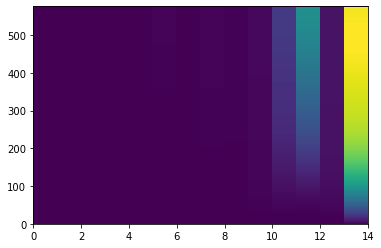

In [45]:
np.count_nonzero(exp_data_merged["idnum"] == 0)

576

In [34]:
normalizer_input = StandardScaler()
normalizer_output = StandardScaler()
input_norm = normalizer_input.fit_transform(input_data)
output_norm = normalizer_output.fit_transform(output_data)

In [39]:
input_layer = Input(input_norm.shape[1])
h1 = Dense(100, activation="tanh")(input_layer)
h2 = Dense(100, activation="tanh")(h1)
out = Dense(output_norm.shape[1])(h2)
mod = Model(input_layer, out)
mod.compile("adam", "mse")

In [40]:
mod.fit(input_norm, output_norm, batch_size=512, epochs=8, validation_split=0.3)

Train on 2173500 samples, validate on 931500 samples
Epoch 1/8
2173500/2173500 [==============================] - 13s 6us/sample - loss: 0.0134 - val_loss: 0.0056
Epoch 2/8
2173500/2173500 [==============================] - 13s 6us/sample - loss: 6.1729e-04 - val_loss: 0.0035
Epoch 3/8
2173500/2173500 [==============================] - 12s 5us/sample - loss: 3.8814e-04 - val_loss: 0.0025
Epoch 4/8
2173500/2173500 [==============================] - 12s 6us/sample - loss: 3.1535e-04 - val_loss: 0.0023
Epoch 5/8
2173500/2173500 [==============================] - 12s 6us/sample - loss: 2.7247e-04 - val_loss: 0.0018
Epoch 6/8
2173500/2173500 [==============================] - 12s 6us/sample - loss: 2.5220e-04 - val_loss: 0.0016
Epoch 7/8
2173500/2173500 [==============================] - 12s 6us/sample - loss: 2.3360e-04 - val_loss: 0.0017
Epoch 8/8
2173500/2173500 [==============================] - 12s 6us/sample - loss: 2.2348e-04 - val_loss: 0.0015


In [41]:
out_preds_norm = mod.predict(input_norm, batch_size=10000)
out_preds = pd.DataFrame(normalizer_output.inverse_transform(out_preds_norm), columns=output_data.columns)

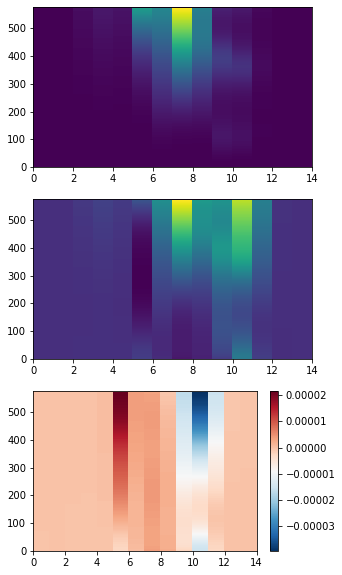

In [63]:
plt.figure(figsize=(5, 10))
plt.subplot(3, 1, 1)
plt.pcolormesh(output_data.loc[:575, output_data.columns.str.contains("Aerosol")])
plt.subplot(3, 1, 2)
plt.pcolormesh(out_preds.loc[:575, output_data.columns.str.contains("Aerosol")])
plt.subplot(3, 1, 3)
plt.pcolormesh(output_data.loc[:575, output_data.columns.str.contains("Aerosol")] - out_preds.loc[:575, output_data.columns.str.contains("Aerosol")], cmap="RdBu_r")
plt.colorbar()

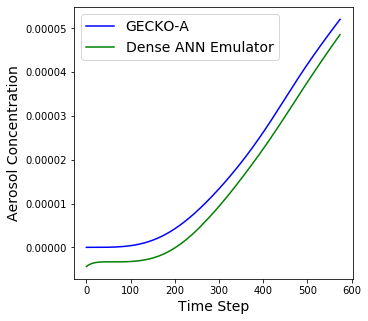

In [93]:
col = output_data.columns[output_data.columns.str.contains("Aerosol")][7]
plt.figure(figsize=(5, 5))
plt.plot(output_data.loc[:574, col], color='blue', label="GECKO-A")

plt.plot(out_preds.loc[:574, col], color="green", label="Dense ANN Emulator")
plt.ylabel("Aerosol Concentration", fontsize=14)
plt.xlabel("Time Step", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("nn_example.png", dpi=200, bbox_inches="tight")

In [68]:
output_data.columns[output_data.columns.str.contains("Aerosol")]

Index(['Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
       'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
       'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
       'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
       'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
       'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
       'Aerosol [ug_m3] Bin14: lg(C*) = -6.5'],
      dtype='object')

In [59]:
(output_data.loc[:575, output_data.columns.str.contains("Gas")] - out_preds.loc[:575, output_data.columns.str.contains("Gas")]).values.max()

6.023957810852298e-06

In [16]:
for col in exp_data_merged.columns:
    print(repr(col))

'Time [s]'
'Precursor [ug/m3]'
'Gas [ug/m3] Bin01: lg(C*) = -5.5'
'Gas [ug/m3] Bin02: lg(C*) = -4.5'
'Gas [ug/m3] Bin03: lg(C*) = -3.5'
'Gas [ug/m3] Bin04: lg(C*) = -2.5'
'Gas [ug/m3] Bin05: lg(C*) = -1.5'
'Gas [ug/m3] Bin06: lg(C*) = -0.5'
'Gas [ug/m3] Bin07: lg(C*) =  0.5'
'Gas [ug/m3] Bin08: lg(C*) =  1.5'
'Gas [ug/m3] Bin09: lg(C*) =  2.5'
'Gas [ug/m3] Bin10: lg(C*) =  3.5'
'Gas [ug/m3] Bin11: lg(C*) =  4.5'
'Gas [ug/m3] Bin12: lg(C*) =  5.5'
'Gas [ug/m3] Bin13: lg(C*) =  6.5'
'Gas [ug/m3] Bin14: lg(C*) = -6.5'
'Aerosol [ug_m3] Bin01: lg(C*) = -5.5'
'Aerosol [ug_m3] Bin02: lg(C*) = -4.5'
'Aerosol [ug_m3] Bin03: lg(C*) = -3.5'
'Aerosol [ug_m3] Bin04: lg(C*) = -2.5'
'Aerosol [ug_m3] Bin05: lg(C*) = -1.5'
'Aerosol [ug_m3] Bin06: lg(C*) = -0.5'
'Aerosol [ug_m3] Bin07: lg(C*) =  0.5'
'Aerosol [ug_m3] Bin08: lg(C*) =  1.5'
'Aerosol [ug_m3] Bin09: lg(C*) =  2.5'
'Aerosol [ug_m3] Bin10: lg(C*) =  3.5'
'Aerosol [ug_m3] Bin11: lg(C*) =  4.5'
'Aerosol [ug_m3] Bin12: lg(C*) =  5.5'
'Aerosol [u

In [9]:
data = pd.read_csv("/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene/ML2019_toluene_kOH_ML2019_Exp0.csv")

In [12]:
for col in data.columns:
    print(col)

 Time [s]
 Precursor [ug/m3]
 Gas [ug/m3] Bin01: lg(C*) = -5.5
 Gas [ug/m3] Bin02: lg(C*) = -4.5
 Gas [ug/m3] Bin03: lg(C*) = -3.5
 Gas [ug/m3] Bin04: lg(C*) = -2.5
 Gas [ug/m3] Bin05: lg(C*) = -1.5
 Gas [ug/m3] Bin06: lg(C*) = -0.5
 Gas [ug/m3] Bin07: lg(C*) =  0.5
 Gas [ug/m3] Bin08: lg(C*) =  1.5
 Gas [ug/m3] Bin09: lg(C*) =  2.5
 Gas [ug/m3] Bin10: lg(C*) =  3.5
 Gas [ug/m3] Bin11: lg(C*) =  4.5
 Gas [ug/m3] Bin12: lg(C*) =  5.5
 Gas [ug/m3] Bin13: lg(C*) =  6.5
 Gas [ug/m3] Bin14: lg(C*) = -6.5
 Aerosol [ug_m3] Bin01: lg(C*) = -5.5
 Aerosol [ug_m3] Bin02: lg(C*) = -4.5
 Aerosol [ug_m3] Bin03: lg(C*) = -3.5
 Aerosol [ug_m3] Bin04: lg(C*) = -2.5
 Aerosol [ug_m3] Bin05: lg(C*) = -1.5
 Aerosol [ug_m3] Bin06: lg(C*) = -0.5
 Aerosol [ug_m3] Bin07: lg(C*) =  0.5
 Aerosol [ug_m3] Bin08: lg(C*) =  1.5
 Aerosol [ug_m3] Bin09: lg(C*) =  2.5
 Aerosol [ug_m3] Bin10: lg(C*) =  3.5
 Aerosol [ug_m3] Bin11: lg(C*) =  4.5
 Aerosol [ug_m3] Bin12: lg(C*) =  5.5
 Aerosol [ug_m3] Bin13: lg(C*) =  6.5
 

In [13]:
exp_data_path = "/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene/ML2019_toluene_postproc/"
exp_data_files = sorted(glob(join(exp_data_path, "ML2019*.csv")))

In [72]:
file_template = "ML2019_toluene_ML2019_{exp}.csv"
exp_data = []
for exp in master_list["id"]:
    filename = join(exp_data_path, f"ML2019_toluene_ML2019_{exp}.csv")
    exp_data.append(pd.read_csv(filename))
    exp_data[-1].insert(0, "id", exp)

In [74]:
all_exp_data = pd.concat(exp_data, ignore_index=True)

In [76]:
all_exp_data.merge(master_list, on="id")

,id,Gas Phase [ug m-3],Aerosol Phase [ug m-3],Precursor [ug m-3],Pvap bin lower limit [log10(Cstar)],Pvap bin upper limit [log10(Cstar)],Time [s],Kh [M/atm],MW [g/mol],Yield (SOA),...,Atomic O/C ratio,Atomic H/C ratio,Atomic N/C ratio,Vaporization Enthalpy [J/mol],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
0,Exp0,0.000000,0.000000e+00,0.000000,-16.0,-6.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
1,Exp0,0.000000,0.000000e+00,0.000000,-6.0,-5.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
2,Exp0,0.000000,0.000000e+00,0.000000,-5.0,-4.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
3,Exp0,0.000000,0.000000e+00,0.000000,-4.0,-3.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
4,Exp0,0.000000,0.000000e+00,0.000000,-3.0,-2.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13547515,Exp1679,0.000037,5.037846e-09,0.000000,2.0,3.0,172800.0,5.974230e+11,190.878196,0.0,...,1.398678,1.001275,0.198914,111930.948306,300,90,0.01,90,10.00,10
13547516,Exp1679,0.007719,1.846604e-07,0.000000,3.0,4.0,172800.0,2.099617e+10,190.256154,0.0,...,0.776976,0.757387,0.310681,98830.435047,300,90,0.01,90,10.00,10
13547517,Exp1679,0.000253,1.129703e-09,0.000000,4.0,5.0,172800.0,1.920989e+10,170.001702,0.0,...,1.410147,0.882486,0.267623,94664.634832,300,90,0.01,90,10.00,10
13547518,Exp1679,0.000652,1.658724e-10,0.000000,5.0,6.0,172800.0,4.678444e+07,124.006908,0.0,...,0.768145,0.866488,0.038317,78111.230330,300,90,0.01,90,10.00,10


In [107]:
exp_0.columns.str.lstrip()

Index(['Gas Phase [ug m-3]', 'Aerosol Phase [ug m-3]', 'Precursor [ug m-3]',
       'Pvap bin lower limit [log10(Cstar)]',
       'Pvap bin upper limit [log10(Cstar)]', 'Time [s]', 'Kh [M/atm]',
       'MW [g/mol]', 'Yield (SOA)', 'Yield (total)', 'Atomic O/C ratio',
       'Atomic H/C ratio', 'Atomic N/C ratio',
       'Vaporization Enthalpy [J/mol]                                                                                                 '],
      dtype='object')

In [64]:
! du -sh /glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene/ML2019_toluene_postproc/

5.2G	/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene/ML2019_toluene_postproc/


In [91]:
exp_0 = pd.read_csv(exp_data_files[42])

In [92]:
times = np.sort(exp_0[" Time [s]"].unique())

In [93]:
bin_aerosol_vectors = exp_0[" Aerosol Phase [ug m-3]"].values.reshape(times.size, 14)

In [94]:
bin_gas_vectors = exp_0[" Gas Phase [ug m-3]"].values.reshape(times.size, 14)

In [95]:
bin_values = exp_0[' Pvap bin lower limit [log10(Cstar)]'][exp_0[" Time [s]"] == times[0]].values
bin_values = np.append(bin_values, [16])

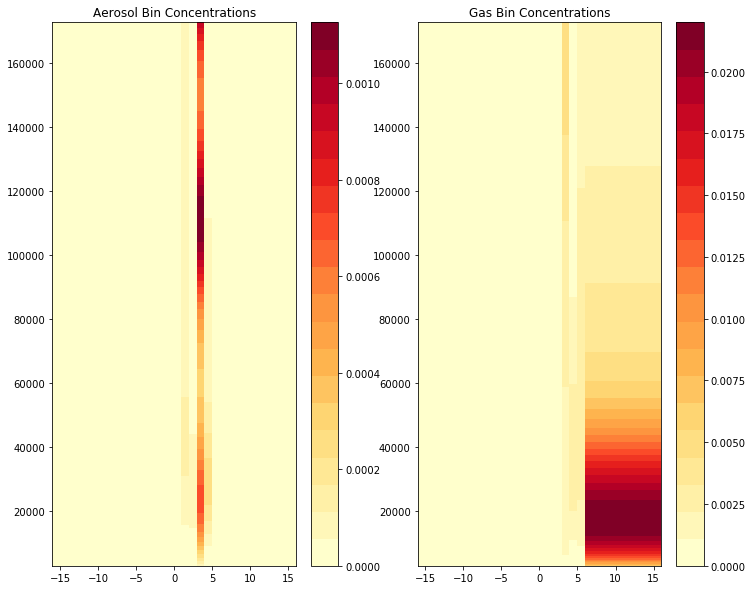

In [104]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.pcolormesh(bin_values, times[10:], bin_aerosol_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20))
plt.title("Aerosol Bin Concentrations")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(bin_values, times[10:], bin_gas_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20))
plt.title("Gas Bin Concentrations")
plt.colorbar()


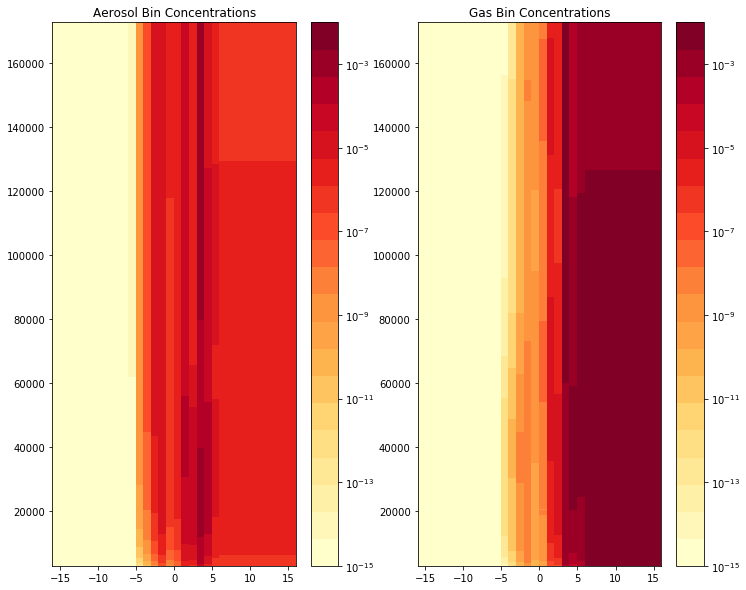

In [103]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.pcolormesh(bin_values, times[10:], bin_aerosol_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20), norm=LogNorm(1e-15, 0.01))
plt.title("Aerosol Bin Concentrations")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(bin_values, times[10:], bin_gas_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20), norm=LogNorm(1e-15, 0.01))
plt.title("Gas Bin Concentrations")
plt.colorbar()


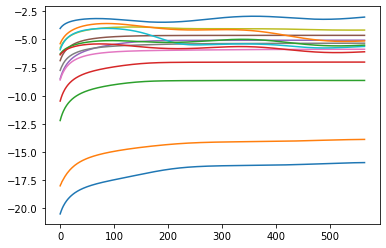

In [105]:
plt.plot(np.log10(bin_aerosol_vectors[10:, :]))

In [82]:
bin_aerosol_vectors.shape

(576, 14)

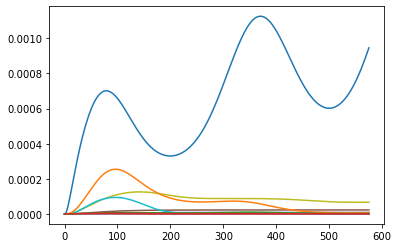

In [98]:
plt.plot(bin_aerosol_vectors)